In [1]:
# 1. Load and preprocess the image data
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Dataset path
data_dir = 'dataset5/images/'  # assume this directory contains subfolders for each class

# Define transforms: convert to grayscale, resize to 224x224, tensor, and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),          # convert images to single-channel (grayscale)
    transforms.Resize((224, 224)),                        # resize to 224x224
    transforms.ToTensor(),                                # convert to tensor [C x H x W] and scale 0-1
    transforms.Normalize(mean=[0.5], std=[0.5])           # normalize to [-1,1] (assuming pixel values 0-1)
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes  # list of class names
num_classes = len(class_names)
print(f"Loaded {len(dataset)} images in {num_classes} classes: {class_names}")

Loaded 555 images in 4 classes: ['Bright', 'Neutral', 'V-shape', 'Warm']


In [2]:


# 2. Split the dataset into training, validation, and test sets (e.g., 70%/15%/15%)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
# Ensure no subset is empty
if train_size == 0 or val_size == 0 or test_size == 0:
    raise ValueError("One of the data splits has size 0. Adjust the split proportions or dataset size.")

# Use random_split for splitting
torch.manual_seed(42)  # set random seed for reproducibility
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size],
                                              generator=torch.Generator().manual_seed(42))
print(f"Dataset split into {len(train_data)} training, {len(val_data)} validation, {len(test_data)} test images.")

# Create DataLoaders for each set
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# 3. Define a 2D CNN architecture for classification

Dataset split into 333 training, 111 validation, 111 test images.


In [4]:

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Convolutional layers with BatchNorm and MaxPooling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # input 1-channel, output 16 channels
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool  = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)
        # Fully connected layers
        # After 4 pool operations on 224x224 input, spatial size is 14x14 and channels = 128
        self.fc1 = nn.Linear(128 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        # Conv + BatchNorm + ReLU + Pool layers
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        # Fully connected layers with ReLU and Dropout
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [5]:

# 4. Train the model with early stopping on validation loss
num_epochs = 300
patience = 30  # early stopping patience
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

train_losses = []
val_losses   = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # accumulate training loss and accuracy
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    epoch_train_loss = running_loss / total_train
    epoch_train_acc  = correct_train / total_train

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc  = correct_val / total_val

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # Print training & validation metrics each epoch
    print(f"Epoch {epoch}: "
          f"Train Loss = {epoch_train_loss:.4f}, Train Acc = {epoch_train_acc:.4f}, "
          f"Val Loss = {epoch_val_loss:.4f}, Val Acc = {epoch_val_acc:.4f}")

    # Check for improvement in validation loss for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}  # save best model weights
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss = 3.5000, Train Acc = 0.4565, Val Loss = 1.2901, Val Acc = 0.3874
Epoch 2: Train Loss = 1.1189, Train Acc = 0.6246, Val Loss = 1.0348, Val Acc = 0.6036
Epoch 3: Train Loss = 0.5660, Train Acc = 0.7538, Val Loss = 0.7643, Val Acc = 0.7568
Epoch 4: Train Loss = 0.4731, Train Acc = 0.7838, Val Loss = 0.4851, Val Acc = 0.8468
Epoch 5: Train Loss = 0.3428, Train Acc = 0.8709, Val Loss = 0.3603, Val Acc = 0.8739
Epoch 6: Train Loss = 0.3321, Train Acc = 0.8619, Val Loss = 0.3232, Val Acc = 0.8829
Epoch 7: Train Loss = 0.2763, Train Acc = 0.8709, Val Loss = 0.3869, Val Acc = 0.8018
Epoch 8: Train Loss = 0.2422, Train Acc = 0.9129, Val Loss = 0.2567, Val Acc = 0.9189
Epoch 9: Train Loss = 0.1852, Train Acc = 0.9369, Val Loss = 0.2286, Val Acc = 0.9099
Epoch 10: Train Loss = 0.1637, Train Acc = 0.9489, Val Loss = 0.2567, Val Acc = 0.8919
Epoch 11: Train Loss = 0.1486, Train Acc = 0.9459, Val Loss = 0.2095, Val Acc = 0.9009
Epoch 12: Train Loss = 0.1872, Train Acc = 0.9369, V

Test Accuracy: 89.19%
Macro F1-score: 85.75%
Confusion matrix (rows=true, cols=pred):
[[ 6  0  1  0]
 [ 2 36  0  5]
 [ 0  0  7  1]
 [ 0  2  1 50]]


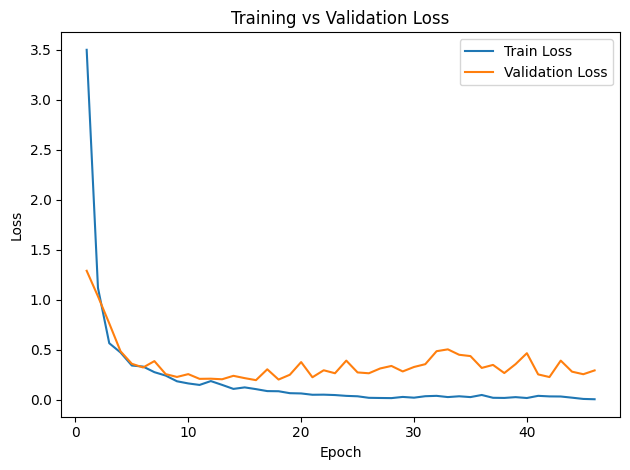

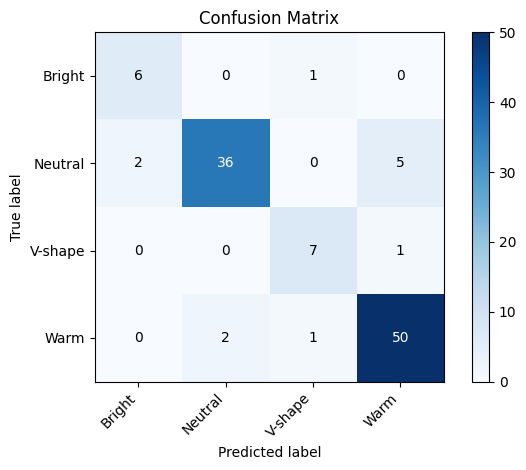

In [7]:
# Load the best model weights before evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model.to(device)

# 5. Evaluate on the test set and report metrics
model.eval()
total_test = 0
correct_test = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # accumulate test accuracy
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)
        # collect all predictions and labels for metrics
        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
test_accuracy = correct_test / total_test

# Compute confusion matrix
conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for t, p in zip(all_labels, all_preds):
    conf_mat[t, p] += 1

# Compute Macro F1-score
f1_scores = []
for i in range(num_classes):
    TP = conf_mat[i, i]
    FN = conf_mat[i].sum() - TP        # false negatives for class i
    FP = conf_mat[:, i].sum() - TP     # false positives for class i
    # precision and recall (handle zero-division)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    # F1 score for class i
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0
    # Consider class i in macro-average if it had at least one sample
    if conf_mat[i].sum() > 0:
        f1_scores.append(f1)
# Macro F1 is average of F1-scores of all classes (that appear in test set)
macro_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0

# Print evaluation metrics
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Macro F1-score: {macro_f1*100:.2f}%")
print("Confusion matrix (rows=true, cols=pred):")
print(conf_mat)

# Plot training vs validation loss curve
plt.figure()
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

# Plot confusion matrix heatmap
plt.figure()
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
# Overlay the counts on the heatmap
thresh = conf_mat.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(conf_mat[i, j]),
                 ha="center", va="center",
                 color="white" if conf_mat[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Show the plots (training curve and confusion matrix)
plt.show()
